In [1]:
import json
import logging
import statistics
import sys
import os
from copy import deepcopy

import matplotlib.pyplot as plt
from tqdm import tqdm
from xopen import xopen

script_dir = os.getcwd()
parent_dir = os.path.dirname(script_dir)
src_dir = os.path.join(parent_dir, 'src')
sys.path.append(src_dir)

from lost_in_the_middle.metrics import best_subspan_em

In [2]:
def load_all_examples(model_predictions_file, default_gold_index = -1): # set gold index to -1 if randomized
    all_examples = []
    examples_by_new_gold_index = {}

    with xopen(model_predictions_file) as fin: 
            for line in tqdm(fin):
                input_example = json.loads(line)
                all_examples.append(input_example)
                new_gold_index = input_example.get("new_gold_index")
                if new_gold_index is not None:
                    examples_by_new_gold_index.setdefault(new_gold_index, []).append(input_example)
    
    return all_examples, examples_by_new_gold_index

In [3]:
def calculate_scores(all_examples):
    example_scores = []
    for i, example in enumerate(all_examples):
        score = best_subspan_em(prediction=example['model_answer'], ground_truths=example['answers'])
        all_examples[i]['score'] = score
        example_scores.append(score)

    average_score = statistics.mean(example_scores)
    return average_score

In [28]:
def plot_scores_by_gold_index(avg_scores_by_gold_index, closed_book=None, open_book=None, gold_label=None, closed_book_label=None, open_book_label=None):
    gold_indexes = list(avg_scores_by_gold_index.keys())
    average_scores = list(avg_scores_by_gold_index.values())

    plt.figure(figsize=(10, 6))
    plt.plot(gold_indexes, average_scores, marker='o', label=gold_label)

    if closed_book:
        plt.axhline(y=closed_book, color='r', linestyle='dashed', label=closed_book_label)

    if open_book:
        plt.axhline(y=open_book, color='g', linestyle='dashed', label=open_book_label)
        
    plt.xticks(gold_indexes)
    plt.title('Average Scores by Gold Index')
    plt.xlabel('Gold Index')
    plt.ylabel('Average Score (best subspan EM)')
    plt.legend()
    plt.grid(True)
    plt.show()

Closed-Book Experiment

In [10]:
closed_book_file = f'../qa_predictions/closed_book/llama-predictions.jsonl.gz'
closed_book_examples, _ = load_all_examples(closed_book_file)
closed_book_average_score = calculate_scores(closed_book_examples)
print(f"Closed Book, LLaMa 2 7B, Average Score: {closed_book_average_score}")

2655it [00:00, 60342.34it/s]

Closed Book, LLaMa 2 7B, Average Score: 0.35856873822975516


Open Oracle Experiment

In [12]:
open_oracle_file = f'../qa_predictions/open_oracle/llama-predictions.jsonl.gz'
open_oracle_examples, _ = load_all_examples(open_oracle_file)
open_oracle_average_score = calculate_scores(open_oracle_examples)
print(f"Open Oracle, LLaMa 2 7B, Average Score: {open_oracle_average_score}")

2655it [00:00, 85650.05it/s]

Open Oracle, LLaMa 2 7B, Average Score: 0.8828625235404897


10 Document Experiment (from LITM paper)

In [15]:
avg_scores_by_gold_index = {}

In [16]:
for i in [0,4,9]:
    gold_at_i_file = f'../qa_predictions/10_total_documents/nq-open-gold_at_{i}-uf-llama-predictions.jsonl.gz'
    gold_at_i_examples, _ = load_all_examples(gold_at_i_file)
    gold_at_i_average_score = calculate_scores(gold_at_i_examples)
    print(f"Gold at {i}, UF LLaMa 2 7B, Average Score: {gold_at_i_average_score}")

    avg_scores_by_gold_index[i] = gold_at_i_average_score

2655it [00:00, 85655.32it/s]


Gold at 0, UF LLaMa 2 7B, Average Score: 0.6214689265536724


2655it [00:00, 74724.39it/s]


Gold at 4, UF LLaMa 2 7B, Average Score: 0.5435028248587571


2655it [00:00, 28089.83it/s]


Gold at 9, UF LLaMa 2 7B, Average Score: 0.47156308851224105


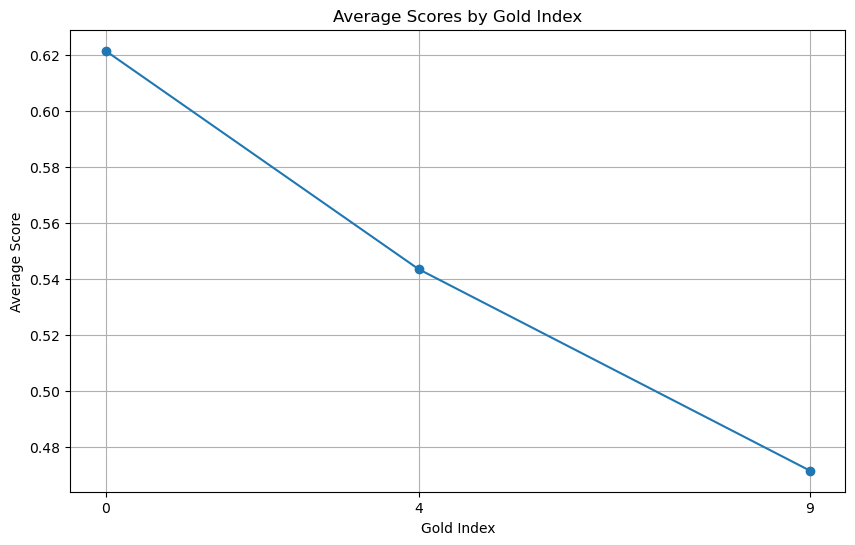

In [17]:
plot_scores_by_gold_index(avg_scores_by_gold_index)

20 Document Experiment (from LITM paper)

In [18]:
avg_scores_by_gold_index = {}

In [19]:
for i in [0,4,9,14,19]:
    gold_at_i_file = f'../qa_predictions/20_total_documents/nq-open-gold_at_{i}-uf-llama-predictions.jsonl.gz'
    gold_at_i_examples, _ = load_all_examples(gold_at_i_file)
    gold_at_i_average_score = calculate_scores(gold_at_i_examples)
    print(f"Gold at {i}, UF LLaMa 2 7B, Average Score: {gold_at_i_average_score}")

    avg_scores_by_gold_index[i] = gold_at_i_average_score

2655it [00:00, 88507.12it/s]


Gold at 0, UF LLaMa 2 7B, Average Score: 0.45160075329566857


2655it [00:00, 85627.00it/s]


Gold at 4, UF LLaMa 2 7B, Average Score: 0.3879472693032015


2655it [00:00, 71483.72it/s]


Gold at 9, UF LLaMa 2 7B, Average Score: 0.37212806026365347


2655it [00:00, 66377.44it/s]


Gold at 14, UF LLaMa 2 7B, Average Score: 0.5717514124293785


2655it [00:00, 87017.40it/s]


Gold at 19, UF LLaMa 2 7B, Average Score: 0.6105461393596987


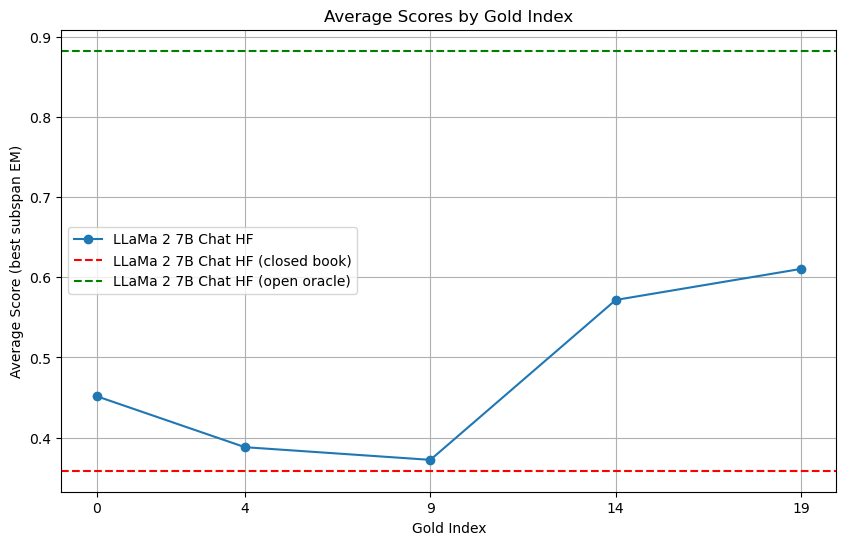

In [29]:
plot_scores_by_gold_index(avg_scores_by_gold_index, 
                          closed_book_average_score, 
                          open_oracle_average_score,
                          gold_label='LLaMa 2 7B Chat HF',
                          closed_book_label='LLaMa 2 7B Chat HF (closed book)',
                          open_book_label='LLaMa 2 7B Chat HF (open oracle)'
)

30 Document Experiment (Randomized Gold Index)

2655it [00:00, 78165.16it/s]


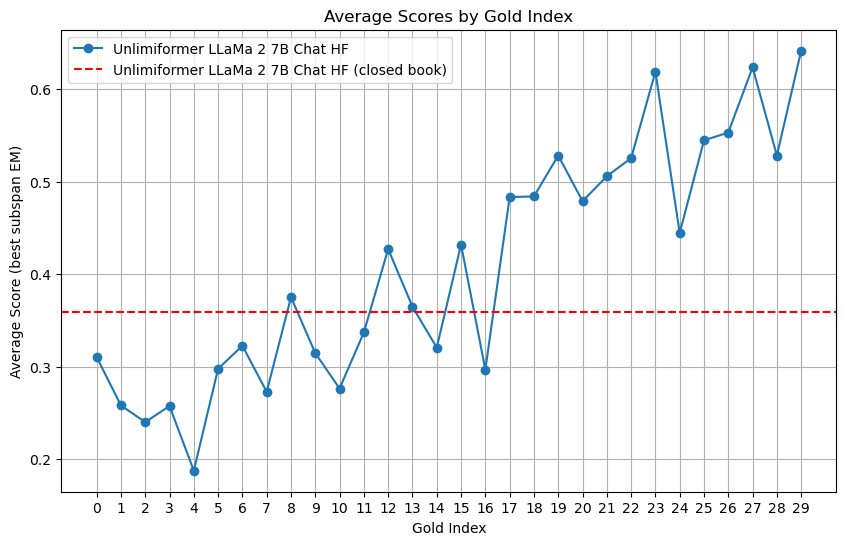

New Gold Index 0: 87 examples
New Gold Index 1: 93 examples
New Gold Index 2: 75 examples
New Gold Index 3: 101 examples
New Gold Index 4: 80 examples
New Gold Index 5: 84 examples
New Gold Index 6: 93 examples
New Gold Index 7: 77 examples
New Gold Index 8: 104 examples
New Gold Index 9: 89 examples
New Gold Index 10: 76 examples
New Gold Index 11: 92 examples
New Gold Index 12: 89 examples
New Gold Index 13: 85 examples
New Gold Index 14: 78 examples
New Gold Index 15: 88 examples
New Gold Index 16: 91 examples
New Gold Index 17: 89 examples
New Gold Index 18: 93 examples
New Gold Index 19: 89 examples
New Gold Index 20: 94 examples
New Gold Index 21: 89 examples
New Gold Index 22: 99 examples
New Gold Index 23: 97 examples
New Gold Index 24: 90 examples
New Gold Index 25: 90 examples
New Gold Index 26: 85 examples
New Gold Index 27: 77 examples
New Gold Index 28: 89 examples
New Gold Index 29: 92 examples


In [31]:
truncated_llama_file = '../qa_predictions/30_total_documents/nq-open-randomized-uf-llama-predictions.jsonl.gz'
all_examples, examples_by_new_gold_index = load_all_examples(truncated_llama_file)

metric_values_by_new_gold_index = {}
counts_by_new_gold_index = {}

for new_gold_index in sorted(examples_by_new_gold_index.keys()):
    metrics = calculate_scores(examples_by_new_gold_index[new_gold_index])
    metric_values_by_new_gold_index[new_gold_index] = metrics

    # Count the number of examples for this new_gold_index
    count = len(examples_by_new_gold_index[new_gold_index])
    counts_by_new_gold_index[new_gold_index] = count

# Plot the scores
plot_scores_by_gold_index(metric_values_by_new_gold_index, 
                          closed_book=closed_book_average_score, 
                          gold_label='Unlimiformer LLaMa 2 7B Chat HF',
                          closed_book_label='Unlimiformer LLaMa 2 7B Chat HF (closed book)'
                        )

# Print the counts
for new_gold_index, count in counts_by_new_gold_index.items():
    print(f"New Gold Index {new_gold_index}: {count} examples")


50 Document Experiment (Randomized Gold Index)

2655it [00:00, 82235.18it/s]
2655it [00:00, 85648.08it/s]
2655it [00:00, 73522.58it/s]
2655it [00:00, 91524.50it/s]
2655it [00:00, 66373.48it/s]


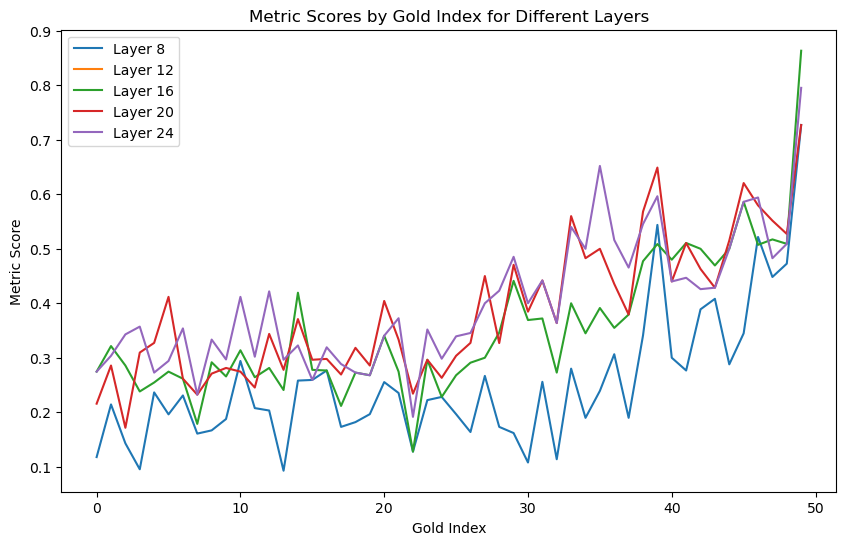

In [33]:
layer_files = {
    8: '../qa_predictions/50_total_documents/nq-open-randomized-uf-llama-predictions-8.jsonl.gz',
    12: '../qa_predictions/50_total_documents/nq-open-randomized-uf-llama-predictions-12.jsonl.gz',
    16: '../qa_predictions/50_total_documents/nq-open-randomized-uf-llama-predictions-16.jsonl.gz',
    20: '../qa_predictions/50_total_documents/nq-open-randomized-uf-llama-predictions-20.jsonl.gz',
    24: '../qa_predictions/50_total_documents/nq-open-randomized-uf-llama-predictions-24.jsonl.gz'
}

metrics_by_layer = {}

for layer, file_path in layer_files.items():
    all_examples, examples_by_new_gold_index = load_all_examples(file_path)
    metric_values_by_new_gold_index = {}

    for new_gold_index in sorted(examples_by_new_gold_index.keys()):
        metrics = calculate_scores(examples_by_new_gold_index[new_gold_index])
        metric_values_by_new_gold_index[new_gold_index] = metrics

    metrics_by_layer[layer] = metric_values_by_new_gold_index

# Plotting
plt.figure(figsize=(10, 6))

for layer, metrics in metrics_by_layer.items():
    gold_indices = list(metrics.keys())
    scores = [metrics[gold_index] for gold_index in gold_indices]
    plt.plot(gold_indices, scores, label=f'Layer {layer}')

plt.xlabel('Gold Index')
plt.ylabel('Metric Score')
plt.title('Metric Scores by Gold Index for Different Layers')
plt.legend()
plt.show()

2655it [00:00, 64766.82it/s]
2655it [00:00, 60519.43it/s]


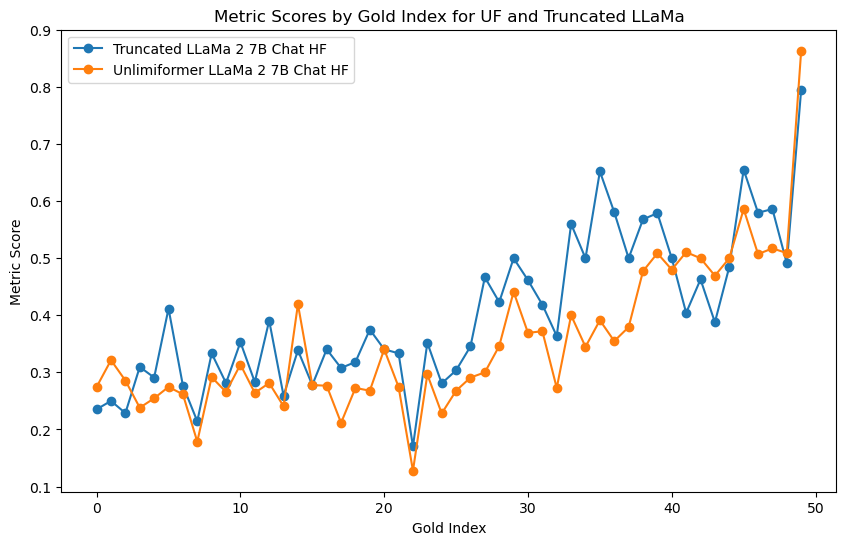

In [41]:
# Load and calculate metrics for truncated LLaMa
truncated_llama_file = f'../qa_predictions/50_total_documents/nq-open-randomized-llama-predictions.jsonl.gz'
truncated_llama_examples, examples_by_new_gold_index = load_all_examples(truncated_llama_file)
truncated_llama_metrics = {}
for new_gold_index in sorted(examples_by_new_gold_index.keys()):
    metrics = calculate_scores(examples_by_new_gold_index[new_gold_index])
    truncated_llama_metrics[new_gold_index] = metrics

# Load and calculate metrics for UF LLaMa (Layer 16)
uf_llama_examples, uf_llama_examples_by_new_gold_index = load_all_examples(layer_files[16])
uf_llama_metrics = {}
for new_gold_index in sorted(uf_llama_examples_by_new_gold_index.keys()):
    metrics = calculate_scores(uf_llama_examples_by_new_gold_index[new_gold_index])
    uf_llama_metrics[new_gold_index] = metrics

# Plotting
plt.figure(figsize=(10, 6))

# Plot for truncated LLaMa
gold_indices_truncated = list(truncated_llama_metrics.keys())
scores_truncated = [truncated_llama_metrics[gold_index] for gold_index in gold_indices_truncated]
plt.plot(gold_indices_truncated, scores_truncated, marker='o', label='Truncated LLaMa 2 7B Chat HF')

# Plot for UF LLaMa (Layer 16)
gold_indices_uf = list(uf_llama_metrics.keys())
scores_uf = [uf_llama_metrics[gold_index] for gold_index in gold_indices_uf]
plt.plot(gold_indices_uf, scores_uf, marker='o', label='Unlimiformer LLaMa 2 7B Chat HF')

plt.xlabel('Gold Index')
plt.ylabel('Metric Score')
plt.title('Metric Scores by Gold Index for UF and Truncated LLaMa')
plt.legend()
plt.show()

Error Analysis

In [58]:
incorrect_count = 0
max_incorrect_display = 5  # Maximum number of incorrect predictions to display
for i, example in enumerate(examples_by_new_gold_index[2]):
    uf_example = uf_llama_examples_by_new_gold_index[2][i]
    if example['score'] == 1.0 and uf_example['score'] == 0.0:
        print("Question:", example['question'])
        print("LLaMa 2 Answer:", example['model_answer'])
        print("UF LLaMa 2 Answer:", uf_example['model_answer'])
        print("Correct Answer:", example['answers'])
        print("\n")  # Adds a new line for readability

        incorrect_count += 1
        if incorrect_count >= max_incorrect_display:
            break  # Stop after displaying 10 incorrect examples

Question: who wrote how do you do it by gerry and the pacemakers
LLaMa 2 Answer:   The song "How Do You Do It?" was written by Mitch Murray.</s>
UF LLaMa 2 Answer:  Based on the information provided in the document, the writers of "How Do You Do It" by Gerry and the Pacemakers are:

* Gerry Marsden and the other band members, Freddie Marsden, Les Chadwick, and Les Maguire.

There is no indication of who specifically wrote the song, but since it was their first number one hit, it is likely that Marsden and the others were involved in writing the song's
Correct Answer: ['Mitch Murray']


Question: what is mercy mercy me by marvin gaye about
LLaMa 2 Answer:  "Mercy Mercy Me (The Ecology)" is a song by American R&B/soul singer and Motown legend Marvin Gaye, released in 1971 on the Motown label. The song is an environmentalist anthem, with lyrics that addressing the mistreatment of the environment and the consequences of pollution. The song's composer, Marvin Gaye, was inspired to write the